<a href="https://colab.research.google.com/github/epetrovic23/Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1/blob/main/epetrovic23_Utjecaj_atmosferskih_prilika_na_ishod_utrka_Formule1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projekt: Analiza utjecaja vremenskih uvjeta na F1 utrke kroz integraciju povijesnih i telemetrijskih podataka**

Programiranje za analizu podataka, Eva Petrović

1. Uvod


Motivacija za ovaj projekt proizlazi iz činjenice da je Formula 1 sport u kojem inženjerska preciznost ovisi o vanjskim faktorima. Vremenski uvjeti (temperatura zraka i staze) drastično utječu na degradaciju guma i performanse motora. Cilj je integrirati povijesne rezultate (iz CSV datoteka) s telemetrijskim podacima o vremenu (iz OpenF1 API-ja) te pohraniti te podatke u bazu za daljnju analizu i ekspoziciju putem REST API-ja.

2. Opis implementacije



Sustav se sastoji od četiri glavne komponente:
ETL proces (Extract, Transform, Load): Učitavanje CSV datoteka i dohvat podataka s javnog OpenF1 API-ja.
Integracija podataka: Spajanje podataka iz različitih izvora (heterogenost: CSV + JSON).
Pohrana: Korištenje SQLite baze podataka putem SQLAlchemy ORM-a.
REST API: Izrada sučelja pomoću Flask okvira za dohvat podataka.
Vizualizacija: Prikaz korelacije temperature i rezultata.

In [1]:
!pip install sqlalchemy flask pandas requests matplotlib seaborn

import pandas as pd
import requests
import sqlite3
from sqlalchemy import create_engine
import json
import threading
import time
from flask import Flask, jsonify, request
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

print("Biblioteke uspješno učitane.")

Biblioteke uspješno učitane.


In [2]:
import pandas as pd
import requests
import time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)


def get_all_weather_2023():
    """Dohvaća temperature za SVE utrke u 2023."""
    print("Dohvaćam popis svih utrka 2023. s OpenF1 API-ja...")
    try:
        sessions = requests.get("https://api.openf1.org/v1/sessions?year=2023&session_name=Race").json()
    except Exception as e:
        return {}

    weather_map = {}
    print(f"Pronađeno {len(sessions)} utrka. Krećem u dohvat vremena (cca 30 sekundi)...")

    for session in sessions:
        date_str = session['date_start'][:10]
        try:
            url = f"https://api.openf1.org/v1/weather?meeting_key={session['meeting_key']}&session_key={session['session_key']}"
            w_resp = requests.get(url).json()
            if w_resp:
                w_df = pd.DataFrame(w_resp)
                weather_map[date_str] = (w_df['track_temperature'].mean(), w_df['air_temperature'].mean())
                print(f"✅ {session['location_option']}: {weather_map[date_str][0]:.1f}°C")
        except:
            pass
        time.sleep(0.2)
    return weather_map

def load_and_analyze():
    print("--- 1. Učitavanje CSV-ova ---")
    try:
        races = pd.read_csv('races.csv')
        results = pd.read_csv('results.csv')
        drivers = pd.read_csv('drivers.csv')
    except FileNotFoundError:
        print("GREŠKA: Nedostaju CSV datoteke (races, results ili drivers).")
        return None

    races_2023 = races[races['year'] == 2023].copy()
    real_weather = get_all_weather_2023()

    def match_weather(row):
        return real_weather.get(row['date'], (None, None))

    races_2023[['track_temp', 'air_temp']] = races_2023.apply(lambda x: pd.Series(match_weather(x)), axis=1)

    races_clean = races_2023.dropna(subset=['track_temp'])
    merged = pd.merge(results, races_clean, on='raceId', how='inner')
    final = pd.merge(merged, drivers, on='driverId', how='left')

    final['Driver'] = final['forename'] + " " + final['surname']

    return final[['raceId', 'year', 'name', 'date', 'Driver', 'positionOrder', 'points', 'track_temp', 'air_temp']]

final_df = load_and_analyze()

if final_df is not None:
    print("\nGotovo! Prvih 5 redova:")
    display(final_df.head())

--- 1. Učitavanje CSV-ova ---
⏳ Dohvaćam popis svih utrka 2023. s OpenF1 API-ja...
Pronađeno 23 utrka. Krećem u dohvat vremena (cca 30 sekundi)...

Gotovo! Prvih 5 redova:


,raceId,year,name,date,Driver,positionOrder,points,track_temp,air_temp
0,1098,2023,Bahrain Grand Prix,2023-03-05,Max Verstappen,1,25.0,31.011801,27.431677
1,1098,2023,Bahrain Grand Prix,2023-03-05,Sergio Pérez,2,18.0,31.011801,27.431677
2,1098,2023,Bahrain Grand Prix,2023-03-05,Fernando Alonso,3,15.0,31.011801,27.431677
3,1098,2023,Bahrain Grand Prix,2023-03-05,Carlos Sainz,4,12.0,31.011801,27.431677
4,1098,2023,Bahrain Grand Prix,2023-03-05,Lewis Hamilton,5,10.0,31.011801,27.431677


In [4]:
from sqlalchemy import create_engine, text

db_name = 'f1_project.db'
engine = create_engine(f'sqlite:///{db_name}')

try:
    if 'final_df' in locals() and final_df is not None:

        final_df.to_sql('race_stats', con=engine, if_exists='replace', index=False)
        print(f"Podaci uspješno spremljeni u bazu '{db_name}', tablica 'race_stats'.")

        with engine.connect() as conn:
            result = conn.execute(text("SELECT count(*) FROM race_stats")).scalar()
            print(f" Broj zapisa u bazi: {result}")

    else:
        print(" Varijabla 'final_df' je prazna ili nije pronađena.")
        print("Prvo pokreni ćeliju iznad (onu veliku s funkcijom load_and_analyze)!")

except NameError:
    print("GREŠKA: Varijabla 'final_df' uopće ne postoji.")
    print("RJEŠENJE: Vrati se na ćeliju iznad i stisni 'Play' da se podaci učitaju.")

✅ Podaci uspješno spremljeni u bazu 'f1_project.db', tablica 'race_stats'.
📊 Broj zapisa u bazi: 440


In [5]:
%%writefile app.py
from flask import Flask, jsonify, request
from sqlalchemy import create_engine
import pandas as pd

app = Flask(__name__)

engine = create_engine('sqlite:///f1_project.db')

@app.route('/', methods=['GET'])
def index():
    return "F1 Data API is running. Use /api/data to get stats."

@app.route('/api/data', methods=['GET'])
def get_data():
    """
    Dohvaća podatke iz baze i vraća ih kao JSON.
    Opcija filtriranja po poziciji (?pos=1 za pobjednike).
    """
    try:
        pos_filter = request.args.get('pos')

        query = "SELECT * FROM race_stats"

        if pos_filter:
            query += f" WHERE positionOrder = {pos_filter}"

        query += " LIMIT 50"

        df = pd.read_sql(query, engine)

        return jsonify(df.to_dict(orient='records'))

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Writing app.py


In [6]:
import subprocess

!fuser -k 5000/tcp

process = subprocess.Popen(["python", "app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

print("Server se pokreće u pozadini...")
time.sleep(3)

try:
    print("Šaljem testni upit na API...")
    response = requests.get("http://127.0.0.1:5000/api/data?pos=1")

    if response.status_code == 200:
        data = response.json()
        print("API Odgovor (Prva 3 zapisa):")
        print(json.dumps(data[:3], indent=2))
    else:
        print("API nije vratio 200 OK.")
except Exception as e:
    print(f"Nije moguće spojiti se na API: {e}")

Server se pokreće u pozadini...
Šaljem testni upit na API...
API Odgovor (Prva 3 zapisa):
[
  {
    "Driver": "Max Verstappen",
    "air_temp": 27.43167701863354,
    "date": "2023-03-05",
    "name": "Bahrain Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1098,
    "track_temp": 31.01180124223602,
    "year": 2023
  },
  {
    "Driver": "Sergio P\u00e9rez",
    "air_temp": 26.09189189189189,
    "date": "2023-03-19",
    "name": "Saudi Arabian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1099,
    "track_temp": 31.79256756756757,
    "year": 2023
  },
  {
    "Driver": "Max Verstappen",
    "air_temp": 17.449549549549552,
    "date": "2023-04-02",
    "name": "Australian Grand Prix",
    "points": 25.0,
    "positionOrder": 1,
    "raceId": 1100,
    "track_temp": 30.13963963963964,
    "year": 2023
  }
]


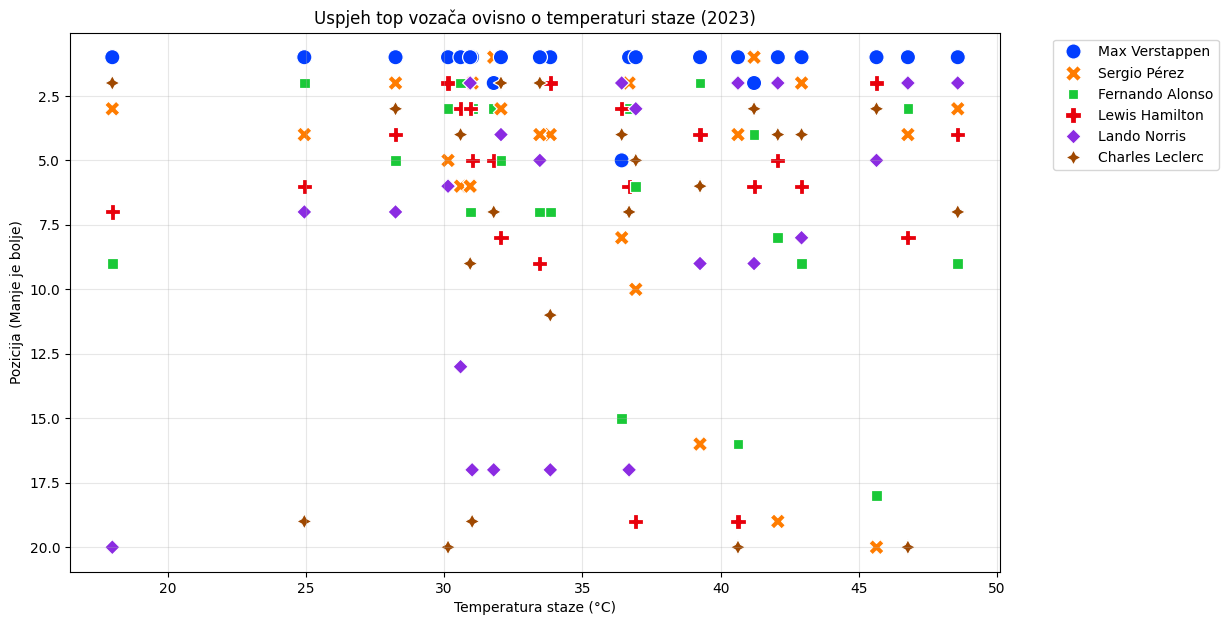

In [7]:
if final_df is not None:
    plt.figure(figsize=(12, 7))

    top_drivers = final_df.groupby('Driver')['points'].sum().sort_values(ascending=False).head(6).index
    df_plot = final_df[final_df['Driver'].isin(top_drivers)]

    sns.scatterplot(
        data=df_plot,
        x='track_temp',
        y='positionOrder',
        hue='Driver',
        style='Driver',
        s=120,
        palette='bright'
    )

    plt.gca().invert_yaxis()
    plt.title('Uspjeh top vozača ovisno o temperaturi staze (2023)')
    plt.xlabel('Temperatura staze (°C)')
    plt.ylabel('Pozicija (Manje je bolje)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()